## 4.10: Coding Etiquette & Excel Reporting

# Table of Contents

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [2]:
# Import Orders_products_all
Orders_products_all = pd.read_pickle(r'/Users/davidscheider/anaconda_projects/Instacart Basket Analysis/02 Data/Prepared Data/Orders_products_all.pkl')

In [3]:
# importing path
path = r'/Users/davidscheider/anaconda_projects/Instacart Basket Analysis'

In [4]:
Orders_products_all.head()

,Unnamed: 0,order_id,customer_id,order_number,orders_day_of_week,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,...,order_frequency_flag,First_Name,Surname,Gender,State,Age,date_joined,n_dependants,fam_status,income
0,0,2539329,1,1,2,8,NaN,196,1,0,...,Non-frequent customer,Linda,Nguyen,Female,Alabama,31,2/17/2019,3,married,40423
1,0,2539329,1,1,2,8,NaN,14084,2,0,...,Non-frequent customer,Linda,Nguyen,Female,Alabama,31,2/17/2019,3,married,40423
2,0,2539329,1,1,2,8,NaN,12427,3,0,...,Non-frequent customer,Linda,Nguyen,Female,Alabama,31,2/17/2019,3,married,40423
3,0,2539329,1,1,2,8,NaN,26088,4,0,...,Non-frequent customer,Linda,Nguyen,Female,Alabama,31,2/17/2019,3,married,40423
4,0,2539329,1,1,2,8,NaN,26405,5,0,...,Non-frequent customer,Linda,Nguyen,Female,Alabama,31,2/17/2019,3,married,40423


Consider any security implications that might exist for this new data. You’ll need to address any PII data in the data before continuing your analysis.

There are clearly PII datapoints in the data frame: First_Name, Surname, Gender, State, Age are problematic. As it's unclear how to deal with them, I just leave them.

# Create a regional segmentation

In [5]:
# Create a mapping dictionary for US states to regions
state_to_region = {
    # West
    'Alaska': 'West', 'California': 'West', 'Hawaii': 'West', 'Nevada': 'West', 'Oregon': 'West', 'Washington': 'West',
    'Arizona': 'West', 'Colorado': 'West', 'Idaho': 'West', 'Montana': 'West', 'New Mexico': 'West', 'Utah': 'West', 'Wyoming': 'West',
    
    # Midwest
    'Illinois': 'Midwest', 'Indiana': 'Midwest', 'Michigan': 'Midwest', 'Ohio': 'Midwest', 'Wisconsin': 'Midwest',
    'Iowa': 'Midwest', 'Kansas': 'Midwest', 'Minnesota': 'Midwest', 'Missouri': 'Midwest', 'Nebraska': 'Midwest', 'North Dakota': 'Midwest', 'South Dakota': 'Midwest',
    
    # South
    'Delaware': 'South', 'Florida': 'South', 'Georgia': 'South', 'Maryland': 'South', 'North Carolina': 'South', 'South Carolina': 'South', 'Virginia': 'South', 'West Virginia': 'South',
    'Alabama': 'South', 'Kentucky': 'South', 'Mississippi': 'South', 'Tennessee': 'South',
    'Arkansas': 'South', 'Louisiana': 'South', 'Oklahoma': 'South', 'Texas': 'South',
    'District of Columbia': 'South',  # Washington D.C.
    
    # Northeast
    'Connecticut': 'Northeast', 'Maine': 'Northeast', 'Massachusetts': 'Northeast', 'New Hampshire': 'Northeast', 'Rhode Island': 'Northeast', 'Vermont': 'Northeast',
    'New Jersey': 'Northeast', 'New York': 'Northeast', 'Pennsylvania': 'Northeast'
}


In [6]:
# clean the state names to handle potential inconsistencies
Orders_products_all_regions = Orders_products_all['State_cleaned'] = Orders_products_all['State'].str.strip().str.title()

In [7]:
# Apply the mapping
Orders_products_all['Region'] = Orders_products_all['State_cleaned'].map(state_to_region)

In [8]:
# Check for any unmapped states
unmapped_states = Orders_products_all[Orders_products_all['Region'].isna()]['State_cleaned'].unique()
if len(unmapped_states) > 0:
    print("Unmapped states found:", unmapped_states)
    # Show original state names for these unmapped states
    print("Original state names for unmapped:")
    for state in unmapped_states:
        original_states = Orders_products_all[Orders_products_all['State_cleaned'] == state]['State'].unique()
        print(f"  {state}: {original_states}")
else:
    print("All states successfully mapped to regions")

Unmapped states found: ['District Of Columbia']
Original state names for unmapped:
  District Of Columbia: ['District of Columbia']


In [9]:
# Clean District of Columbia
state_variations = {
    'District Of Columbia': 'South'}

In [10]:
# Update the main mapping with variations
state_to_region.update(state_variations)

In [11]:
# Re-apply mapping with variations included
Orders_products_all['Region'] = Orders_products_all['State_cleaned'].map(state_to_region)

In [12]:
# Check again for unmapped states
unmapped_states = Orders_products_all[Orders_products_all['Region'].isna()]['State_cleaned'].unique()
if len(unmapped_states) > 0:
    print("Still unmapped states:", unmapped_states)
    # You can manually add these to the mapping if needed
else:
    print("All states now successfully mapped to regions")

All states now successfully mapped to regions


In [13]:
# Display the region distribution
print("\nRegion Distribution:")
print(Orders_products_all['Region'].value_counts())


Region Distribution:
Region
South        10792300
West          8293217
Midwest       7597585
Northeast     5722939
Name: count, dtype: int64


There are 10178586 customers in the region "South", 8293217 customers in the region "West", 7597585 customers in the region "Midwest" and 5722939 customers in the region "Northeast".

Correction after data cleaning: 10792300 customer are located in the "South" region.

In [14]:
# Show sample of the mapping
print("\nSample of state-to-region mapping:")
sample_mapping = Orders_products_all[['State', 'State_cleaned', 'Region']].drop_duplicates().head(10)
print(sample_mapping)


Sample of state-to-region mapping:
                    State         State_cleaned     Region
0                 Alabama               Alabama      South
59                 Alaska                Alaska       West
254               Arizona               Arizona       West
342              Arkansas              Arkansas      South
360            California            California       West
397              Colorado              Colorado       West
411           Connecticut           Connecticut  Northeast
617              Delaware              Delaware      South
666  District of Columbia  District Of Columbia      South
742               Florida               Florida      South


# Analyze Spending Habits by Region

In [15]:
# Cross-tabulate Region with Spending Flag
spending_by_region = pd.crosstab(Orders_products_all['Region'], Orders_products_all['order_frequency_flag'], normalize='index') * 100

print("Spending Distribution by Region (%):")
print(spending_by_region.round(2))

Spending Distribution by Region (%):
order_frequency_flag  Frequent customer  Non-frequent customer  \
Region                                                           
Midwest                           66.04                  11.37   
Northeast                         66.48                  11.01   
South                             66.65                  11.26   
West                              66.87                  11.19   

order_frequency_flag  Regular customer  
Region                                  
Midwest                          22.59  
Northeast                        22.51  
South                            22.09  
West                             21.95  


In [16]:
# Create a more detailed analysis
spending_counts = pd.crosstab(Orders_products_all['Region'], Orders_products_all['order_frequency_flag'], margins=True)
print("\nSpending Counts by Region:")
print(spending_counts)


Spending Counts by Region:
order_frequency_flag  Frequent customer  Non-frequent customer  \
Region                                                           
Midwest                         5017781                 863531   
Northeast                       3804573                 630210   
South                           7192610                1215183   
West                            5545360                 927783   
All                            21560324                3636707   

order_frequency_flag  Regular customer       All  
Region                                            
Midwest                        1716273   7597585  
Northeast                      1288156   5722939  
South                          2384502  10792295  
West                           1820074   8293217  
All                            7209005  32406036  


The differences in spending habits are rather marginal. There are slightly more frequent customer in the West (66.87 %) than in the other regions. The differences are barely more than half a percentage point, though.

# create exlusion flag for low-activity customers (customers with less than 5 orders)

In [17]:
# Step 1: Count number of orders per customer
customer_order_counts = Orders_products_all.groupby('customer_id')['order_number'].nunique().reset_index()
customer_order_counts.rename(columns={'order_number': 'total_orders'}, inplace=True)

In [18]:
# Step 2: Create a flag for low-activity customers
customer_order_counts['low_activity_flag'] = customer_order_counts['total_orders'] < 5

In [19]:
# Step 3: Merge flag back into main dataset
Orders_products_all = Orders_products_all.merge(customer_order_counts[['customer_id', 'low_activity_flag']], 
                                                 on='customer_id', how='left')

In [20]:
# Step 4: Filter out low-activity customers
Orders_products_filtered = Orders_products_all[~Orders_products_all['low_activity_flag']].copy()

In [21]:
# Export file
Orders_products_filtered.to_csv(os.path.join(path, '02 Data','Prepared Data','Orders_products_filtered.csv'))

In [22]:
Orders_products_filtered.head()

,Unnamed: 0,order_id,customer_id,order_number,orders_day_of_week,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,...,Gender,State,Age,date_joined,n_dependants,fam_status,income,State_cleaned,Region,low_activity_flag
0,0,2539329,1,1,2,8,NaN,196,1,0,...,Female,Alabama,31,2/17/2019,3,married,40423,Alabama,South,False
1,0,2539329,1,1,2,8,NaN,14084,2,0,...,Female,Alabama,31,2/17/2019,3,married,40423,Alabama,South,False
2,0,2539329,1,1,2,8,NaN,12427,3,0,...,Female,Alabama,31,2/17/2019,3,married,40423,Alabama,South,False
3,0,2539329,1,1,2,8,NaN,26088,4,0,...,Female,Alabama,31,2/17/2019,3,married,40423,Alabama,South,False
4,0,2539329,1,1,2,8,NaN,26405,5,0,...,Female,Alabama,31,2/17/2019,3,married,40423,Alabama,South,False


# Create a profiling variable based on age, income, certain goods in the “department_id” column, and number of dependents

In [23]:
def assign_profile(row):
    age = row['Age']
    income = row['income']
    dependants = row['n_dependants']
    dept = row['department_id']
    hour = row['order_hour_of_day']
    day = row['orders_day_of_week']

    # Young Singles
    if age < 30 and dependants == 0 and income < 50000:
        return 'Young Single'

    # Young Parents
    elif age < 35 and dependants > 0 and dept == 18:  # 18 = Baby products
        return 'Young Parent'

    # Middle-Aged Family
    elif 35 <= age <= 55 and dependants > 1:
        return 'Middle-age Family'

    # Seniors
    elif age > 60:
        return 'Senior'

    # Health Conscious
    elif dept in [4, 12]:  # e.g., 4 = produce, 12 = meat seafood
        return 'Health Conscious'

    # Busy Professional
    elif day in [0,1,2,3,4] and 18 <= hour <= 21:
        return 'Busy Professional'

    # Weekend Shopper
    elif day in [5,6]:  # Saturday & Sunday
        return 'Weekend Shopper'

    else:
        return 'General Customer'

# Apply the profiling function
Orders_products_all['customer_profile'] = Orders_products_all.apply(assign_profile, axis=1)

# Visualiazation

/var/folders/bz/7hwgnc95287cp83lwy4gfzth0000gn/T/ipykernel_1319/2039548200.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=Orders_products_all, x='customer_profile', order=Orders_products_all['customer_profile'].value_counts().index, palette='viridis')


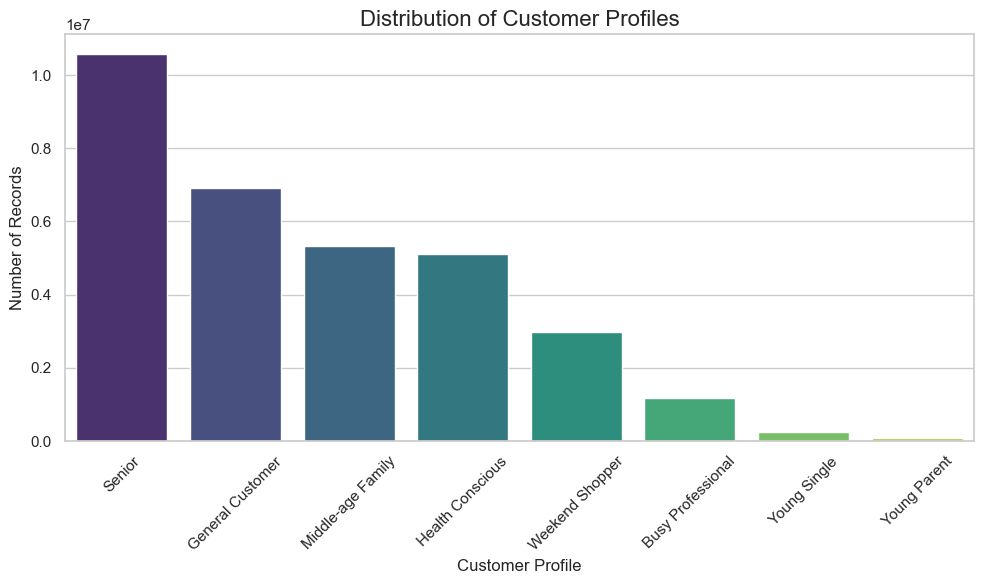

In [25]:
# Set the visual style
sns.set(style="whitegrid")

# Set the figure size
plt.figure(figsize=(10,6))

# Plot the counts of each customer profile
sns.countplot(data=Orders_products_all, x='customer_profile', order=Orders_products_all['customer_profile'].value_counts().index, palette='viridis')

# Add labels and title
plt.title('Distribution of Customer Profiles', fontsize=16)
plt.xlabel('Customer Profile', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


# Aggregate the max, mean, and min variables on a customer-profile level for usage frequency and expenditure

In [27]:
# Group by customer profile and aggregate
agg_df = Orders_products_all.groupby('customer_profile').agg({
    'order_number': ['max', 'mean', 'min'],  # usage frequency proxy
    'prices': ['max', 'mean', 'min']         # expenditure
})

# Flatten the column multi-index
agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]
agg_df = agg_df.reset_index()

# Rename columns for clarity
agg_df.rename(columns={
    'order_number_max': 'usage_freq_max',
    'order_number_mean': 'usage_freq_mean',
    'order_number_min': 'usage_freq_min',
    'prices_max': 'expenditure_max',
    'prices_mean': 'expenditure_mean',
    'prices_min': 'expenditure_min'
}, inplace=True)

print(agg_df)

    customer_profile  usage_freq_max  usage_freq_mean  usage_freq_min  \
0  Busy Professional              99        15.855046               1   
1   General Customer              99        17.150858               1   
2   Health Conscious              99        17.736270               1   
3  Middle-age Family              99        17.017403               1   
4             Senior              99        17.134541               1   
5    Weekend Shopper              99        16.834481               1   
6       Young Parent              99        19.375992               1   
7       Young Single              99        16.657599               1   

   expenditure_max  expenditure_mean  expenditure_min  
0          99999.0         12.823039              1.0  
1          99999.0         13.922144              1.0  
2             25.0          8.568652              1.0  
3          99999.0         12.022354              1.0  
4          99999.0         11.845765              1.0  
5     

# Compare your customer profiles with regions and departments

In [29]:
# Ensure proper data types
df = Orders_products_all.copy()

# 1. Profile counts by Region
profile_region_ct = pd.crosstab(df['customer_profile'], df['Region'], normalize='index') * 100

# 2. Profile counts by Department
profile_dept_ct = pd.crosstab(df['customer_profile'], df['department_id'], normalize='index') * 100

# Round for neatness
profile_region_ct = profile_region_ct.round(1)
profile_dept_ct = profile_dept_ct.round(1)

print("📍 Customer Profile vs Region (%):")
print(profile_region_ct)

print("\n🛒 Customer Profile vs Department (%):")
print(profile_dept_ct)

📍 Customer Profile vs Region (%):
Region             Midwest  Northeast  South  West
customer_profile                                  
Busy Professional     23.8       17.6   33.4  25.1
General Customer      23.6       17.5   33.1  25.7
Health Conscious      23.6       17.5   33.4  25.5
Middle-age Family     23.2       17.6   33.6  25.6
Senior                23.3       17.9   33.2  25.6
Weekend Shopper       23.6       17.4   33.3  25.6
Young Parent          24.3       18.0   33.9  23.8
Young Single          23.2       19.2   31.0  26.7

🛒 Customer Profile vs Department (%):
department_id        1    2    3     4    5    6     7    8    9    10  ...  \
customer_profile                                                        ...   
Busy Professional  11.2  0.2  5.2   0.0  0.6  1.2  11.7  0.5  4.0  0.2  ...   
General Customer    9.7  0.2  5.3   0.0  0.7  1.3  12.3  0.4  4.0  0.2  ...   
Health Conscious    0.0  0.0  0.0  93.0  0.0  0.0   0.0  0.0  0.0  0.0  ...   
Middle-age Family   6.

Nothing too specific can be derived from this analysis. 'Young Singles' are especially prevalent in the West but that's about it.

In [30]:
# Copy your DataFrame
df = Orders_products_all.copy()

# Create output directory if not exists
output_dir = "charts_output"
os.makedirs(output_dir, exist_ok=True)

# Profile vs Region
profile_region_ct = pd.crosstab(df['customer_profile'], df['Region'], normalize='index') * 100
profile_region_ct = profile_region_ct.round(1)

# Profile vs Department
profile_dept_ct = pd.crosstab(df['customer_profile'], df['department_id'], normalize='index') * 100
profile_dept_ct = profile_dept_ct.round(1)

# Chart 1: Heatmap - Profile vs Region
plt.figure(figsize=(10, 6))
sns.heatmap(profile_region_ct, cmap='coolwarm', annot=True)
plt.title('Customer Profile Distribution by Region (%)', fontsize=14)
plt.ylabel('Customer Profile')
plt.xlabel('Region')
plt.tight_layout()
plt.savefig(f"{output_dir}/profile_vs_region_heatmap.png")
plt.close()

# Chart 2: Heatmap - Profile vs Department
plt.figure(figsize=(16, 6))
sns.heatmap(profile_dept_ct, cmap='YlGnBu', annot=True)
plt.title('Customer Profile Distribution by Department (%)', fontsize=14)
plt.ylabel('Customer Profile')
plt.xlabel('Department ID')
plt.tight_layout()
plt.savefig(f"{output_dir}/profile_vs_department_heatmap.png")
plt.close()

# Chart 3: Stacked Bar Plot - Region breakdown per profile
profile_region_ct.T.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='tab20')
plt.title('Stacked Barplot: Regional Breakdown per Customer Profile', fontsize=14)
plt.ylabel('Percentage (%)')
plt.xlabel('Region')
plt.legend(title='Customer Profile', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f"{output_dir}/stacked_bar_region_profile.png")
plt.close()

print("✅ Charts successfully saved to:", os.path.abspath(output_dir))

✅ Charts successfully saved to: /Users/davidscheider/anaconda_projects/Instacart Basket Analysis/03 Scripts/charts_output


Charts exported to files and included in the final excel

In [31]:
# exporting to pkl
Orders_products_all.to_pickle(os.path.join(path, '02 Data','Prepared Data','Orders_products_all_final.pkl'))